In the following, all the code blocks directly related to `pastax` are opened by default,
while the closed ones are not required to learn about the library.

In [1]:
import jax
jax.config.update("jax_enable_x64", True)

## Defining a velocity field

In the following, we will use an idealized configuration (inspired by [this one](https://docs.oceanparcels.org/en/latest/examples/parcels_tutorial.html#Running-particles-in-an-idealised-field) from Parcels documentation) where the velocity field $\mathbf{u}$ presents two eddies displaced over time.

We consider a spatial domain spanning from 29° to 31° latitude and -1° to 1° longitude, and a time period of two days.

In [2]:
import jax.numpy as jnp


ny = nx = 101
nt = 49

lat = jnp.linspace(29, 31, ny)
lon = jnp.linspace(-1, 1, nx)

dt = jnp.asarray(1*60*60)  # 1 hour in seconds
ts = jnp.linspace(0, dt * (nt - 1), nt)  # discretize interval of 2 days in seconds

Below we defined the $\mathbf{u}_u$ and $\mathbf{u}_v$ fields, considering circular and geostrophic eddies.

In [3]:
from pastax.utils.unit import degrees_to_meters


dy, dx = degrees_to_meters(jnp.asarray([lat[1] - lat[0], lon[1] - lon[0]]), lat.mean())

# SSH field parameters
eta0 = .4
sig = 0.1
eta_fn = lambda _dx, _dy: eta0 * jnp.exp(-(_dx / (sig * nx))**2 - (_dy / (sig * ny))**2)
xi, yi = jnp.meshgrid(jnp.arange(lon.size), jnp.arange(lat.size), indexing="ij")

# eddies displacement parameters
eddy_speed = .05
dxi = eddy_speed * dt / dx
dyi = eddy_speed * dt / dy

# SSH field
eta = jnp.zeros((nt, ny, nx))
for t in range(nt):
    # eddy 1
    x1 = 0.5 * lon.size - (8 + dxi * t)
    y1 = 0.5 * lat.size - (8 + dyi * t)
    eta = eta.at[t, :, :].add(eta_fn((x1 - xi), (y1 - yi)))

    # eddy 2
    x2 = 0.5 * lon.size + (8 + dxi * t)
    y2 = 0.5 * lat.size + (8 + dyi * t)
    eta = eta.at[t, :, :].add(-eta_fn((x2 - xi), (y2 - yi)))

# geostrophic velocities
coriolis_factor = 2 * 7.292115e-5 * jnp.sin(jnp.radians(lat.mean()))
g = 9.81

u = jnp.zeros_like(eta)
u = u.at[:, :-1, :].set(jnp.diff(eta[:, :, :], axis=1) / dy / coriolis_factor * g)
u = u.at[:, -1, :].set(u[:, -2, :])

v = jnp.zeros_like(eta)
v = v.at[:, :, :-1].set(-jnp.diff(eta[:, :, :], axis=-1) / dx / coriolis_factor * g)
v = v.at[:, :, -1].set(v[:, :, -2])

We can animate $\| \mathbf{u} \|$ over time to observe how the eddies separate.

In [28]:
import cmocean.cm as cmo
from IPython.display import HTML
from matplotlib import animation
import matplotlib.pyplot as plt


plt.ioff()


fig, ax = plt.subplots()

im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt(u[0]**2 + v[0]**2), 
    vmax=2.75, vmin=0,
    cmap=cmo.speed
)
ax.set_aspect("equal")

clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
_ = clb.ax.set_title("m/s")

quiver = ax.quiver(
    lon[::5], lat[::5], 
    u[0][::5, ::5], v[0][::5, ::5],
    scale=50
)

title = ax.set_title(f"$t$ = {ts[0] / 60 / 60:.0f}h")


def draw_frame(i):
    im.set_array(jnp.sqrt(u[i]**2 + v[i]**2).ravel())
    quiver.set_UVC(u[i][::5, ::5], v[i][::5, ::5])
    title.set_text(f"$t$ = {ts[i] / 60 / 60:.0f}h")

    return im, quiver, title


def init_func():
    return draw_frame(0)


anim = animation.FuncAnimation(fig, draw_frame, init_func=init_func, frames=nt, interval=100, blit=True)
HTML(anim.to_html5_video())

In order to interpolate this velocity field during simulations of trajectories, we define a [`pastax.grid.Dataset`][] (a `xarray.Dataset`-likish object compatible with JAX just-in-time compilation mechanism).

In [5]:
from pastax.grid import Dataset


two_eddies_ds = Dataset.from_arrays(
    variables={"u": u, "v": v},  # the fields
    time=ts, latitude=lat, longitude=lon,  # the coordinates
)

## Simulating trajectories

The initial position of the simulated trajectories is chosen to be right in between the two eddies: 30° latitude and 0° longitude.
We use [`pastax.trajectory.Location`][] structure to represent positions.

In [6]:
from pastax.trajectory import Location


x0 = Location([30, 0])

We also define the time range of the simulated trajectory, and the initial integration timestep.

In [7]:
ts_sim = ts[1:-1]
dt0 = jnp.asarray(15*60)  # integration timestep: 15 minutes in seconds

### Generating a single trajectory

Let's start with the simplest use-case: advecting a single particle inside a given velocity field $\mathbf{u}$.

For this, we will use a [`pastax.simulator.DeterministicSimulator`][] simulator, and a [`pastax.simulator.dynamics.linear_uv`][] dynamics.

??? example "Formulation"

    This combination of simulator and dynamics formulates the displacement at time $t$ from the position $\mathbf{X}(t)$ as:

    $$
    d\mathbf{X}(t) = \mathbf{u}(t, \mathbf{X}(t)) dt
    $$

    by interpolating the velocity field $\mathbf{u}$ in space and time.

In [8]:
from pastax.simulator import DeterministicSimulator
from pastax.simulator.dynamics import linear_uv

traj_sim = DeterministicSimulator()
uv_dynamics = linear_uv

[`pastax.simulator.Simulator`][] simulators are *callables* returning a simulated [`pastax.trajectory.Trajectory`][] (or a [`pastax.trajectory.TrajectoryEnsemble`][] as we will see later).

In [9]:
traj = traj_sim(dynamics=uv_dynamics, args=two_eddies_ds, x0=x0, ts=ts_sim, dt0=dt0)

We can plot it using its [`pastax.trajectory.Trajectory.plot`][] method.

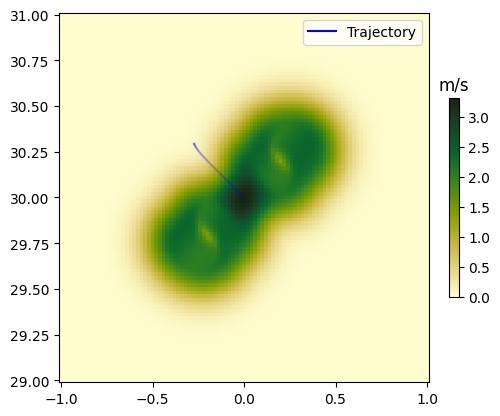

In [10]:
plt.close()

fig, ax = plt.subplots()

# plot the field
im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt((u**2 + v**2)).max(axis=0),  # max over time
    cmap=cmo.speed, vmin=0
)
ax.set_aspect("equal")

clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
clb.ax.set_title("m/s")

# add the trajectory
ax = traj.plot(ax, label="Trajectory", color="blue")
ax.legend()

plt.show()

Because the particle is released between the eddies, its trajectory does not represent neither of the eddies, which might not seem very realistic.

To remedy this, we will generate a stochastic ensemble of trajectories.

### Sampling an ensemble of trajectories

Instead of a single trajectory, we will now simulate an ensemble of 100 trajectories by sampling solutions from a Stochastic Differential Equation with Smagorinsky diffusion using the [`pastax.simulator.StochasticSimulator`][] simulator, and a [`pastax.simulator.dynamics.SmagorinskyDiffusion`][].

??? example "Formulation"

    This combination of simulator and dynamics formulates a displacement at time $t$ from the position $\mathbf{X}(t)$ as:

    $$
    d\mathbf{X}(t) = (\mathbf{u} + \nabla K)(t, \mathbf{X}(t)) dt + V(t, \mathbf{X}(t)) d\mathbf{W}(t)
    $$

    where $V = \sqrt{2 K}$ and $K$ is the Smagorinsky diffusion:
    
    $$
    K = C_s \Delta x \Delta y \sqrt{\left(\frac{\partial u}{\partial x} \right)^2 + \left(\frac{\partial v}{\partial y} \right)^2 + \frac{1}{2} \left(\frac{\partial u}{\partial y} + \frac{\partial v}{\partial x} \right)^2}
    $$

    where $C_s$ is the ***tunable*** Smagorinsky constant, $\Delta x \Delta y$ a spatial scaling factor, and the rest of the expression represents the horizontal diffusion.

In [11]:
from pastax.simulator import StochasticSimulator
from pastax.simulator.dynamics import SmagorinskyDiffusion


n_samples = jnp.asarray(100)

ens_sim = StochasticSimulator()
smag_dynamics = SmagorinskyDiffusion(cs=1e-1)

traj_ens = ens_sim(dynamics=smag_dynamics, args=two_eddies_ds, x0=x0, ts=ts_sim, dt0=dt0, n_samples=n_samples)

This time, the simulator returns a [`pastax.trajectory.TrajectoryEnsemble`][].
Again, we can plot the trajectories using the [`pastax.trajectory.TrajectoryEnsemble.plot`][] method.

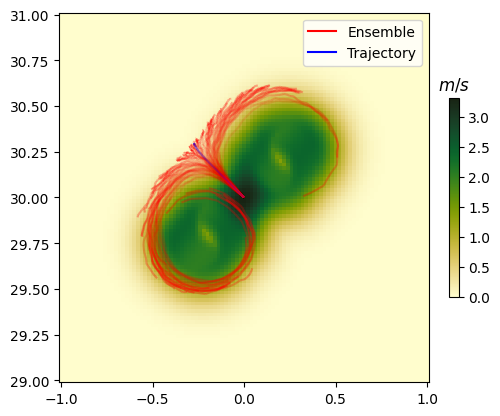

In [12]:
fig, ax = plt.subplots()

# plot the field
im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt((u**2 + v**2)).max(axis=0),  # max over time
    cmap=cmo.speed, vmin=0
)
ax.set_aspect("equal")

clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
clb.ax.set_title("$m/s$")

# add the ensemble
ax = traj_ens.plot(ax, label="Ensemble", color="red")

# add the trajectory on top
ax = traj.plot(ax, label="Trajectory", color="blue")
ax.legend()

plt.show()

We see that the ensemble much better represent the presence of the two eddies.

## Learning simulators parametrization

Using [`JAX`](https://jax.readthedocs.io/) we have the ability to write fully differentiable simulators and learn their parametrization (even for a large number of parameters, such as a neural network).

To demonstrate how we can do this, we will stick to our idealized velocity field $\mathbf{u}$ and consider a ***reference*** (pair of simulator and) dynamics ($\mathcal{S}_\text{ref}$) whose output will be considered as the truth and a ***tunable*** (pair of simulator and) dynamics ($\mathcal{S}_\text{tun}$) that we will want to calibrate according to the truth.

To make the demonstration more interesting, we are going to use a different initial position and start inside the leftward eddy.

In [13]:
x0 = Location([29.95, -0.05])

### In the deterministic case

Here, the ***reference*** dynamics knows and uses $\mathbf{u}$ to simulate the ***true*** trajectory.
The ***tunable*** dynamics uses as input a modified version of the velocity field: $\widehat{\mathbf{u}} = (\mathbf{u} - b) / a$, and apply the linear transformation $x \mapsto \beta_0 + x \beta_1$ to $\widehat{\mathbf{u}}$ to simulate an ***estimated*** trajectory.

Starting from randomly sampled $\beta_0$ and $\beta_1$, we will (hopefully) learn their expected values $b$ and $a$ by minimizing (using a gradient-based optimizer) a metric $\mathcal{L}$ quantifying the distance between the ***true*** and ***estimated*** trajectories:

$$
(\beta_0^*, \beta_1^*) = \underset{\beta_0, \beta_1}{\operatorname{argmin}} \mathcal{L}(\mathcal{S}_\text{ref}(t_0, \mathbf{X}_0), \mathcal{S}_\text{tun}(t_0, \mathbf{X}_0))
$$

In [14]:
true_ds = two_eddies_ds  # same as before

# velocity field transofrmation parameters
a = 2
b = 0.1

# transformed velocity field
trans_u = (u - b) / a
trans_v = (v - b) / a
trans_ds = Dataset.from_arrays(
    variables={"u": trans_u, "v": trans_v},  # the fields
    time=ts, latitude=lat, longitude=lon,  # the coordinates
)

As before, we use a [`pastax.simulator.dynamics.linear_uv`][] dynamics for the ***reference*** $\mathcal{S}_\text{ref}$.
For the ***tunable*** one $\mathcal{S}_\text{tun}$, we use a [`pastax.simulator.dynamics.LinearUV`][], whose `intercept` and `slope` attributes can be optimized.

In [15]:
import jax.random as jrd

from pastax.simulator.dynamics import LinearUV


ref_dynamics = linear_uv

keys = jrd.split(jrd.key(0), 2)
intercept = jrd.uniform(keys[0], 1, dtype=float, minval=-1, maxval=1)
slope = jrd.uniform(keys[1], 1, dtype=float, minval=-1, maxval=1)
tun_dynamics = LinearUV(intercept=intercept, slope=slope)

print(f"Initial parameters: (intercept={intercept.item()}, slope={slope.item()})")

Initial parameters: (intercept=-0.03947928024531988, slope=0.15310165206863147)


Let's see how the true and estimated trajectories compare...

In [16]:
true_traj = traj_sim(dynamics=ref_dynamics, args=true_ds, x0=x0, ts=ts_sim, dt0=dt0)
est_traj_init = traj_sim(dynamics=tun_dynamics, args=trans_ds, x0=x0, ts=ts_sim, dt0=dt0)

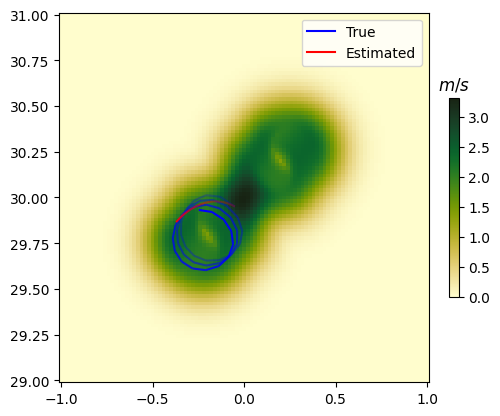

In [17]:
fig, ax = plt.subplots()

# plot the field
im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt((u**2 + v**2)).max(axis=0), 
    cmap=cmo.speed, vmin=0
)
ax.set_aspect("equal")

clb = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.02, pad=0.04)
clb.ax.set_title("$m/s$")

# add the reference
ax = true_traj.plot(ax, label="True", color="blue")

# add the estimation
ax = est_traj_init.plot(ax, label="Estimated", color="red")
ax.legend()

plt.show()

As expected given the sampled values of $\beta_0$ and $\beta_1$, the estimated trajectory is quite far from the true one.

To improve this estimation by adjusting the parameters $\beta_0$ and $\beta_1$ using gradient descent and automatic differentiation, we essentially need to define our objective function (or loss) $\mathcal{L}$ to minimize, and a minimizer.

There is plenty of options for the choice objective function, including:

- the Liu Index,
- the Separation distance (distance on Earth in meters),
- the Euclidean distance (distance in degrees),
- ...

that we can evaluate either at the final position of the particle or along its full trajectory.

In this case, we will use the sum of the Liu Index calculated every hour between the true and the estimated trajectories, that we square to ease minimization.

In [18]:
import equinox as eqx


nansum = lambda x: jnp.nansum(x.value)  # the liu index is not defined at the first timestep


def objective_fn(traj):
    return nansum(true_traj.liu_index(traj))**2 / 2


@eqx.filter_value_and_grad
def val_grad_obj_fn(dynamics):
    traj = traj_sim(dynamics=dynamics, args=trans_ds, x0=x0, ts=ts_sim, dt0=dt0)
    return objective_fn(traj)

!!! note
    [`pastax.trajectory.Trajectory`][] objects define several methods to compute metrics or distances between trajectories, such as `liu_index` here.

!!! note
    We use [`Equinox`](https://docs.kidger.site/equinox/) to represent and manipulate (e.g. `vmap`, `grad`, `jit`...) Python structures as PyTrees.

We can verify it is possible to evaluate the loss and its gradients.

In [19]:
loss, grads = val_grad_obj_fn(tun_dynamics)

print(
    f"Initial loss: {loss} and "
    f"gradients: (intercept={grads.intercept.item()}, slope={grads.slope.item()})"
)

Initial loss: 134.52295580884825 and gradients: (intercept=297.0417452723851, slope=-60.2415824903312)


Thanks to [`Optax`](https://optax.readthedocs.io/), we have access to a large variety of optimizers.
In this example we will use the classical Adam but many more are available.

In [20]:
import optax


learning_rate = 1e-1

optim = optax.adam(learning_rate)
opt_state = optim.init(tun_dynamics)

Because we rely on [`Equinox`](https://docs.kidger.site/equinox/), it is also straightforward to apply gradient-based updates to the dynamics attributes (as it is a PyTree).

In [21]:
@eqx.filter_jit
def make_step(dynamics, opt_state):
    loss, grads = val_grad_obj_fn(dynamics)
    updates, opt_state = optim.update(grads, opt_state)
    dynamics = eqx.apply_updates(dynamics, updates)
    return loss, dynamics, opt_state

!!! note
    This function should be jitted.

Finally, we perform the optimization over 200 update steps:

In [22]:
n_steps = 200

dyns = [tun_dynamics,]
trajs = [est_traj_init,]
losses = []
for step in range(n_steps):
    loss, tun_dynamics, opt_state = make_step(tun_dynamics, opt_state)
    dyns.append(tun_dynamics)
    trajs.append(traj_sim(dynamics=tun_dynamics, args=trans_ds, x0=x0, ts=ts_sim, dt0=dt0))
    losses.append(loss)
losses.append(objective_fn(trajs[-1]))

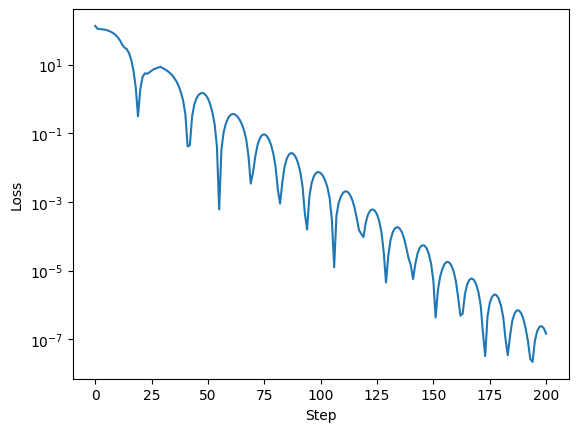

In [23]:
fig, ax = plt.subplots()

ax.plot(jnp.asarray(losses).ravel())

ax.set_yscale("log")
ax.set_xlabel("Step")
ax.set_ylabel("Loss")

plt.show()

After optimization, the fitted parameters of the calibrated simulator correspond to their expected values:

In [24]:
print(f"Final parameters: (intercept={tun_dynamics.intercept.item()}, slope={tun_dynamics.slope.item()})")

Final parameters: (intercept=0.10001865141685615, slope=2.0000309632744266)


Therefore, we should now find a very good agreement between the two trajectories.

In [25]:
est_traj_final = trajs[-1]

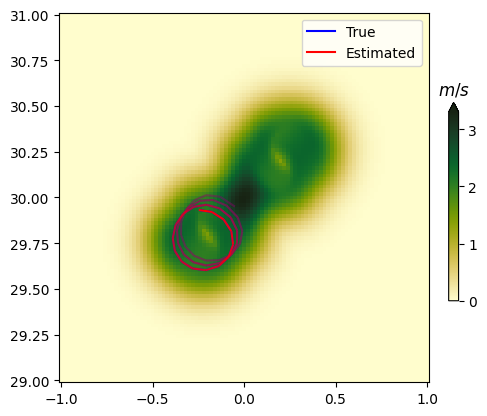

In [26]:
fig, ax = plt.subplots()

# plot the field
im = ax.pcolormesh(
    lon, lat,
    jnp.sqrt((u**2 + v**2)).max(axis=0), 
    cmap=cmo.speed, vmin=0, vmax=jnp.sqrt((u**2 + v**2)).max()
)
ax.set_aspect("equal")

clb = fig.colorbar(im, ax=ax, extend="max", orientation="vertical", fraction=0.02, pad=0.04)
clb.ax.set_title("$m/s$")

# add the reference
ax = true_traj.plot(ax, label="True", color="blue")

# add the estimation
ax = est_traj_final.plot(ax, label="Estimated", color="red")

ax.legend()

plt.show()

And indeed, in this toy use-case, we were able to perfectly simulate the reference trajectory.

!!! tip "Bonus"

    We can take a look at what happened during the optimization process.

    In particular, how the "corrected" transformed velocity field evolved, and how it affected the ***estimated*** trajectory.
    We can also track the evaluation of the objective function and the euclidean distance between the estimated and expected parameters along the optimization.

In [27]:
def params_distance(dynamics):
    return jnp.sqrt((dynamics.intercept - b)**2 + (dynamics.slope - a)**2).item()


def format_out_float(x):
    if x < 1e-3:
        return f"{x:.3e}"
    else:
        return f"{x:.5f}"
    

def corrected_vel_norm(dynamics):
    return jnp.sqrt(
        (trans_u * dynamics.slope + dynamics.intercept)**2 + 
        (trans_v * dynamics.slope + dynamics.intercept)**2
    ).max(axis=0)


def info_text(dynamics, loss):
    loss_text = f"Trajectory loss: {format_out_float(loss)}"
    param_text = f"Simulator parameters error: {format_out_float(params_distance(dynamics))}"
    return f"{loss_text}\n{param_text}"


est_lines = ax.collections[-1]
text = ax.text(
    0.03, 0.965, "", 
    transform=ax.transAxes, fontsize=10,
    verticalalignment="top", bbox={"boxstyle": "round", "facecolor": "white", "alpha": 0.75}
)
title = ax.set_title("")


def draw_step(i):
    dynamics = dyns[i]
    traj = trajs[i]
    loss = losses[i]

    im.set_array(corrected_vel_norm(dynamics).ravel())

    locations = traj.locations.value[:, None, ::-1]
    segments = jnp.concat([locations[:-1], locations[1:]], axis=1)
    est_lines.set_segments(segments)

    text.set_text(info_text(dynamics, loss))

    title.set_text(f"step: {i}")

    return im, est_lines, text, title


def init_func():
    return draw_step(0)


anim = animation.FuncAnimation(fig, draw_step, init_func=init_func, frames=n_steps, interval=100, blit=True)
HTML(anim.to_html5_video())